In [4]:
import matplotlib.pyplot as plt
import qiskit
from qiskit.algorithms import VQE
import qiskit_nature
import qiskit_nature.problems.second_quantization
import qiskit_nature.drivers.second_quantization
import qiskit_nature.transformers.second_quantization.electronic
import qiskit_nature.algorithms
from qiskit_nature.drivers import Molecule
import numpy as np

In [2]:
def get_qubit_op(molecule,remove_orbitals):
    driver = qiskit_nature.drivers.second_quantization.ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=qiskit_nature.drivers.second_quantization.ElectronicStructureDriverType.PYSCF)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = qiskit_nature.problems.second_quantization.ElectronicStructureProblem(
        driver,
        remove_orbitals)

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = qiskit_nature.mappers.second_quantization.ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = qiskit_nature.converters.second_quantization.QubitConverter(mapper,two_qubit_reduction=True)
    reducer = qiskit.opflow.TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [5]:
def exact_solver(problem, converter):
    solver = qiskit_nature.algorithms.NumPyMinimumEigensolverFactory()
    calc = qiskit_nature.algorithms.GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = qiskit.BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = qiskit.algorithms.optimizers.SLSQP(maxiter=5)
for dist in distances:
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0] ],
            ["H", [dist, 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(molecule,
                                                                [qiskit_nature.transformers.second_quantization.electronic.FreezeCoreTransformer(
                                                                    freeze_core=True,
                                                                    remove_orbitals=[-3,-2])])
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = qiskit_nature.circuit.library.HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = qiskit_nature.circuit.library.UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

/var/folders/yk/_rb14s1j5tg2qcj87ml0w1n80000gn/T/ipykernel_41011/4289922393.py:24: NatureDeprecationWarning: The qiskit_nature.problems.second_quantization.electronic.ElectronicStructureProblem class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.problems.ElectronicStructureProblem class.
  problem, converter) = get_qubit_op(molecule,


KeyError: 0

ValueError: x and y must have same first dimension, but have shapes (18,) and (0,)

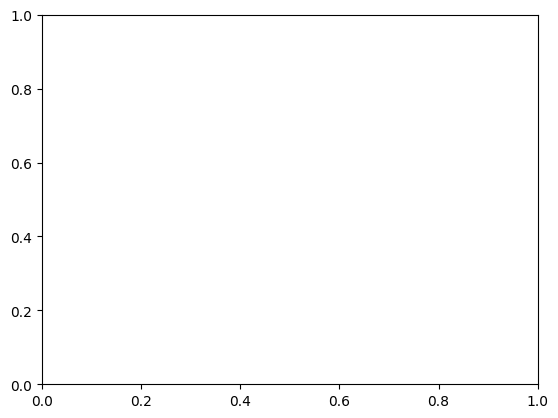

In [6]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [7]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)], charge=0, multiplicity=1)

driver = PySCFDriver.from_molecule(molecule, basis="sto3g")

# this is now done explicitly
problem = driver.run()

transformer = FreezeCoreTransformer()

# and you also apply transformers explicitly
problem = transformer.transform(problem)

hamiltonian = problem.hamiltonian.second_q_op()
print("\n".join(str(hamiltonian).splitlines()[:10] + ["..."]))

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.4718960072811418 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.4718960072811418 * ( +_3 -_3 )
+ 0.3378550774017583 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211575 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211567 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276485 * ( +_0 +_1 -_1 -_0 )
...


In [8]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)], charge=0, multiplicity=1)

driver = PySCFDriver.from_molecule(molecule, basis="sto3g")

result = driver.run()
print(type(result))

<class 'qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem'>


In [9]:
from qiskit_nature.second_q.formats.fcidump import FCIDump

path_to_fcidump = "aux_files/h2.fcidump"
fcidump = FCIDump.from_file(path_to_fcidump)
print(type(fcidump))

from qiskit_nature.second_q.formats.fcidump_translator import fcidump_to_problem

problem = fcidump_to_problem(fcidump)
print(type(problem))

QiskitNatureError: "Input file 'aux_files/h2.fcidump' cannot be read!"